#QUINCY HERSHEY - ALEX MOORE - ADAM DICHIARA - SCOTT TANG - VINCENT FILARDI
#CS541 Project: MAML CNN
---


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
from collections import OrderedDict
import copy
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

dir = '/content/drive/MyDrive/Project/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## RESISC45

---

In [3]:
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate1 = 0.00045
MAML_learning_rate2 = 0.0001
alpha= 0
CNN_learning_rate = 0.0006
n_epochs = 20
freeze=False
First_Train = True
bce_loss = nn.BCELoss()
order=True
reptile=True

In [4]:
class CustomTensorDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform=transform

    def __getitem__(self, index):
        X = self.images[index]
        y = self.labels[index]
        return X, y

    def __len__(self):
        return len(self.images)

def make_dataset(x, y):
    x = torch.tensor(x).permute(0,3,1,2)
    y = torch.tensor(y)
    dset = CustomTensorDataset(x, y)
    return dset

In [5]:
def get_data(dir, mtype):
    if mtype=='MAML': batch_n = batch_size*2
    else: batch_n = batch_size

    data = np.load(dir+'data/RESISC45_images_96.npy')
    labels = np.load(dir+'data/RESISC45_classes.npy')
    classes = np.load(dir+'data/RESISC45_class_names.npy')

    #img_size = train_data.shape[2]
    c_dim = classes.shape[0]

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size, stratify = labels)

    xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = val_size)

    trainset = make_dataset(xtrain,ytrain)
    train_loader = DataLoader(trainset, batch_size=int(batch_n), shuffle=True)

    valset = make_dataset(xval, yval)
    val_loader = torch.utils.data.DataLoader(valset, batch_n, drop_last = True, shuffle=True)

    testset = make_dataset(test_data, test_labels)
    test_loader = torch.utils.data.DataLoader(testset, batch_n, drop_last = True, shuffle=True)

    return train_loader, val_loader, test_loader, c_dim, classes

In [6]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (batch_size, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        self.fce = nn.Linear(1024, 45)


    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        x = x/127.5 - 1.0
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))

        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z

    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
            }, dir+'/test/'+name+'_8task.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+'/test/'+name+'_8task.pt')
        self.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def get_model(mtype, lr=0.0006, train=True,firsttrain=True):
    model = Conv_Pred().to(device)
    model.weight_init()
    if not firsttrain:
        try: model.load(mtype)
        except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)

def one_hot_embedding(labels, dims):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = dims)
    return torch.squeeze(labels)

def accuracy_topk(output, target, topk=(3,)):
    #https://forums.fast.ai/t/return-top-k-accuracy/27658
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

In [7]:
#augmentation_functions.py

class addGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=0.5):
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)
        self.p = p
      
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return img + torch.randn(img.size(), device = device) * self.std + self.mean
        return img
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={2})'.format(self.mean, self.std, self.p)

def applyAugs(img_batch, task_idx, num_augs=7):
    # returns augmented batch of images based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(96,
                                                   scale=(0.5, 1.0),
                                                   ratio=(0.8, 1.0)),
                                                   #interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)
    img_batch = transform(img_batch)
    return img_batch

def getAugmentationTransforms(task_idx, num_augs=7):
    # returns transforms.Compose function of transforms based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(256,
                                                   scale=(0.5, 1.0),
                                                   ratio=(1.0, 1.0),
                                                   interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)

    return transform

# utility functions
# images must be normalized and converted to torch shape before augmentations (3,h,w)
# converted to numpy shape for displaying (h,w,3)

def normalizeImages(x):
  x = x/255.
  return x

def convertToTorch(x):
  x = np.moveaxis(x, 3, 1)
  x = torch.as_tensor(x)
  return x

def convertToNumpy(x):
  # convert back to format for displaying
  x = x.numpy()
  x = np.moveaxis(x, 1, 3)  
  return x

In [8]:
# def train(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype):
#     epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
#     i = 0
#     tasks = 128
#     print_stride = n_epochs // 10

#     model = get_model(mtype=mtype)
#     if mtype=='MAML' and not order:
#         model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)
#         n=1
#     elif order:
#         n=16
#         model_optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0)

#     else:
#         model_optimizer = optim.Adam(model.parameters(), lr = learning_rate1)
#         n=1
#     for epoch in range(1, n_epochs+1):

#         losses = []
#         j=0
#         TasksInOuterSum = n
#         pred_loss=torch.tensor(0.)
#         model3=copy.deepcopy(model).to(device)## we will store all the grads here in this model it will act as a container
#         for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o

#         for X, y in train_loader:
#             i = torch.randint(high=127, size=(1, 1)).item()
#             y = one_hot_embedding(y, c_dim).float().to(device)

#             if mtype=='MAML':
#                 ## I added support for having the outer loop contain multiple tasks, it has been cited by Cheasea finn, 
#                 #the creator of MAML for fast adaption this is where the model does the most work the outerloop, so we will back load it with 256 images instead of 32
#                 # This will be done by doing the update of the j variable is a multiple of n, for instance if n is = 8 in the code see line  so we get 8*32=256 images all form same tasks as the inner loop per outer update

#                 ## start inner loop
#                 ## with first order we update the models weights after each inner loop to prevent the hessian update
#                 ## We wish to find a good intiiallzation point for all tasks so this inner loop should either have a small learning rate or a regularizer
#                 ## I will use a regulizer to enforce some closeness to the initial point, note te more images we have in the outer loop update step the further we will be 
#                 ## from the initialization point, ideally maml without any apoximation calls aims to acheive this
                
#                 ## get logits with the loss for the inner loop
#                 model1 = copy.deepcopy(model).to(device)
#                 model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1,weight_decay =alpha)
                
#                 X = applyAugs(X.float().clone().to(device), int(i))
#                 task_batch1 = X[:int(X.shape[0]/2)].float().clone().to(device)
#                 task_batch2 = X[int(X.shape[0]/2):].float().clone().to(device) ## now each batch
#                 y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
#                 y2 = y[int(y.shape[0]/2):].float().clone().to(device)    ## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper
#                 for param in model1.parameters(): param.grad = None
#                 for param in model.parameters(): param.grad = None

#                 inner_logit = model1(task_batch1)
#                 inner_loss = bce_loss(inner_logit, y1)
#                 inner_loss.backward() ## innner backwards
#                 model1_optimizer.step() ## inner loss update not on orginal model
#                 losses += [inner_loss.item()]
#                 if reptile==True:
#                     for k in range(2): ## do 1+4 inner updates, choose 4 since convienint, 1 since the one outside
#                         xi,yi = next(iter(train_loader))
#                         xi = applyAugs(X.float().clone().to(device), int(i))
#                         task_batch1 = xi[:int(xi.shape[0]/2)].float().clone().to(device)
#                         task_batch2 = xi[int(xi.shape[0]/2):].float().clone().to(device) ## now each batch
#                         y1i = yi[:int(yi.shape[0]/2)].float().clone().to(device)
#                         y2i = yi[int(yi.shape[0]/2):].float().clone().to(device)    ## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper
#                         for param in model1.parameters(): param.grad = None
#                         inner_logit = model1(task_batch1)
#                         inner_loss = bce_loss(inner_logit, y1)
#                         inner_loss.backward()
#                         model1_optimizer.step()
#                         model1_optimizer.zero_grad()
#                         ##second innder loop itteration and fourth too
#                         inner_logit = model1(task_batch2)
#                         inner_loss = bce_loss(inner_logit, y2)
#                         inner_loss.backward()
#                         model1_optimizer.step()
#                         model1_optimizer.zero_grad()
#                 for param in model.parameters(): param.grad = None
#                 for param in model1.parameters(): param.grad = None

#                 ## now with the updated_params dict we will take outerloop without updating the params on the inner loop
#                 outer_logit =  model1(task_batch2) ## get outer logits  with inner loss's params
#                 outer_loss = bce_loss(outer_logit,y2)
#                 outer_loss.backward()

#                 if reptile == True:
#                     for m1, m2,m3 in zip(model.parameters(), model3.parameters(),model3.parameters()): ## add weights to container
#                         m3 = (m2 - m1).div(5) ## 5 is for the number of steps in inner loop, in essence we in, we avg the inner loops
#                 else:
#                     for m1, m2 in zip(model3.named_parameters(), model1.named_parameters()): ## add weights to container
#                         m1[1].grad = m1[1].grad + m2[1].grad.clone()/TasksInOuterSum ## 8 is for the number of baths for non reptile inner loops, we avg the inner loops, wheather right or wrong this constant it is absorbed in the LR for the outer step

#                 ## we will now update the model after seeing our n tasks with j%n
#                 ## time to clone
#                 if j%TasksInOuterSum ==0:
#                     if reptile:
#                         for m1, m2 in zip(model.parameters(), model3.parameters()):
#                             m1 = m1 + (m2).div(TasksInOuterSum)
#                     else:    
#                         for m1, m2 in zip(model.named_parameters(), model3.named_parameters()):
#                             m1[1].grad = m2[1].grad.clone()
#                         ## do the update here
#                         model_optimizer.step()
#                     for param in model.parameters(): param.grad = None
#                     for param in model1.parameters(): param.grad = None
#                     if reptile:
#                         model3=copy.deepcopy(model).to(device)## we will store all the grads here in this model it will act as a container
#                         for param in model3.parameters(): param.grad = None ## in reptile it keeps intial weights of the model post update
#                         ## we will store all the grads here in this model it will act as a container
#                     else:
#                         for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o
#                 losses += [outer_loss.item()]
    
#             else: 
              
#                 X = X.float().clone().to(device)
#                 t = np.random.randint(tasks)
#                 task_batch = applyAugs(X, t).to(device)

#                 for param in model.parameters(): param.grad = None

#                 yhat = model(task_batch)
#                 pred_loss = bce_loss(yhat, y)
#                 pred_loss.backward()
#                 ## moved these inside, We only wish to do it for the cnn
#                 model_optimizer.step()
#             losses += [pred_loss.item()]
            
        
#         if epoch % print_stride == 0:
#             print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

#             loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
#             with torch.no_grad():
#                 accs, actk = [], []
#                 for x, y in val_loader:
#                     x, y = x.to(device).float(), y.to(device).float()
#                     yhat = model(x)
                    
#                     yhat_max = torch.max(yhat, dim = 1)[1]
                    
#                     correct = torch.sum(yhat_max == y)
#                     size = x.shape[0]

#                     acc_topk = accuracy_topk(yhat, y)
#                     actk.append(acc_topk.data.item())
                    
#                     accs.append(100*(correct/size).data.item())

#                 print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
#                 print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
                
#             val_accs.append(torch.mean(torch.FloatTensor(accs)))
#             val_topks.append(torch.mean(torch.FloatTensor(actk)))
#             epoch_tracker.append(epoch)
                
          

#     model.save(mtype)

#     return val_accs,val_topks
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate1 = 0.00045
MAML_learning_rate2 = 0.0001
alpha= .08
CNN_learning_rate = 0.0006
n_epochs = 80
freeze=False
First_Train = True ## note added to not load in params, always set to true in the get_model fucntion
bce_loss = nn.BCELoss()
order=True
mtype='MAML'
def train2(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128
    print_stride = n_epochs // 10

    model = get_model(mtype=mtype)
    if mtype=='MAML' and not order:
        model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)
        n=1
    elif order:
        n=16
        model_optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0)

    else:
        model_optimizer = optim.Adam(model.parameters(), lr = learning_rate1)
        n=1
    for epoch in range(1, n_epochs+1):

        losses = []
        j=0
        TasksInOuterSum = n
        pred_loss=torch.tensor(0.)
        model3=copy.deepcopy(model).to(device)## we will store all the grads here in this model it will act as a container
        for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o

        for X, y in train_loader:
            i = torch.randint(high=127, size=(1, 1)).item()
            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML':
                ## I added support for having the outer loop contain multiple tasks, it has been cited by Cheasea finn, 
                #the creator of MAML for fast adaption this is where the model does the most work the outerloop, so we will back load it with 256 images instead of 32
                # This will be done by doing the update of the j variable is a multiple of n, for instance if n is = 8 in the code see line  so we get 8*32=256 images all form same tasks as the inner loop per outer update
                X = applyAugs(X.float().clone().to(device), int(i))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper

                ## data prep for inner and outer loop
                task_batch1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                task_batch2 = X[int(X.shape[0]/2):].float().clone().to(device) ## now each batch
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)
                ## start inner loop
                ## with first order we update the models weights after each inner loop to prevent the hessian update
                ## We wish to find a good intiiallzation point for all tasks so this inner loop should either have a small learning rate or a regularizer
                ## I will use a regulizer to enforce some closeness to the initial point, note te more images we have in the outer loop update step the further we will be 
                ## from the initialization point, ideally maml without any apoximation calls aims to acheive this
                
                ## get logits with the loss for the inner loop
                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1,weight_decay =alpha)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                inner_logit = model1(task_batch1)
                inner_loss = bce_loss(inner_logit, y1)
                inner_loss.backward() ## innner backwards
                model1_optimizer.step() ## inner loss update not on orginal model
                losses += [inner_loss.item()]

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                ## now with the updated_params dict we will take outerloop without updating the params on the inner loop
                outer_logit =  model1(task_batch2) ## get outer logits  with inner loss's params
                outer_loss = bce_loss(outer_logit,y2)
                outer_loss.backward()

                for m1, m2 in zip(model3.named_parameters(), model1.named_parameters()): ## add weights to container
                    m1[1].grad = m1[1].grad + m2[1].grad.clone()/8

                ## we will now update the model after seeing our n tasks with j%n
                ## time to clone
                if j%TasksInOuterSum ==0:
                    for m1, m2 in zip(model.named_parameters(), model3.named_parameters()):
                        m1[1].grad = m2[1].grad.clone()
                    ## do the update here
                    model_optimizer.step()
                    for param in model.parameters(): param.grad = None
                    for param in model1.parameters(): param.grad = None
                    for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o
                losses += [outer_loss.item()]
    
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)
                task_batch = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(task_batch)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()
                ## moved these inside, We only wish to do it for the cnn
                model_optimizer.step()
            losses += [pred_loss.item()]
            
        
        print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

        loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
        
        with torch.no_grad():
            accs, actk = [], []
            for x, y in val_loader:
                x, y = x.to(device).float(), y.to(device).float()
                yhat = model(x)
                
                yhat_max = torch.max(yhat, dim = 1)[1]
                
                correct = torch.sum(yhat_max == y)
                size = x.shape[0]

                acc_topk = accuracy_topk(yhat, y)
                actk.append(acc_topk.data.item())
                
                accs.append(100*(correct/size).data.item())

            print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
            print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
            
        val_accs.append(torch.mean(torch.FloatTensor(accs)))
        val_topks.append(torch.mean(torch.FloatTensor(actk)))
        epoch_tracker.append(epoch)
                
    if order==True:
        mtype1= mtype + '16task'      
    np.save(dir+'/test/'+mtype1+'_loss_tracker_task.npy', loss_tracker) 
    np.save(dir+'/test/'+mtype1+'_val_topks_task.npy', val_topks)
    np.save(dir+'/test/'+mtype1+'_val_accs_task.npy', val_accs)
    np.save(dir+'/test/epoch_tracker_task.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker

In [9]:
def make_example(train_loader, classes):
    print('Shape of a batch of images: ', next(iter(train_loader))[0].shape)
    print('Shape of a batch of labels: ', next(iter(train_loader))[1].shape)

    first_samp = next(iter(train_loader))[0][0] #get first sample in first batch
    plt.imshow(first_samp.permute(1,2,0)/255) #show it

    name = next(iter(train_loader))[1][0].data.item()
    print(name, classes[name])
    return first_samp

def make_train_plot(MAML_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_val_accs, MAML_val_topks, CNN_val_topks, epoch_tracker):
    #plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    #plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    plt.plot(epoch_tracker, MAML_val_accs, label = 'MAML val acc')
    plt.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc')
    plt.plot(epoch_tracker, MAML_val_topks, label = 'MAML val top3')
    plt.plot(epoch_tracker, CNN_val_topks, label = 'CNN_val top3')
    plt.legend(loc = 'best')
    plt.show()

def make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_val_accs):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    ax1.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    ax1.legend(loc = 'best')
    ax2.plot(epoch_tracker, MAML_val_accs, label = 'MAML val acc')
    ax2.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc')
    ax2.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

def basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_loss_tracker):
    plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    plt.legend(loc = 'best')
    plt.show()

def make_test(model, testloader):
    with torch.no_grad():
        model.eval()
        accs, topks = [], []
        for x, y in testloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)
            yhat_max = torch.max(yhat, dim = 1)[1]
            correct = torch.sum(yhat_max == y)
            size = x.shape[0]
            acc_topk = accuracy_topk(yhat, y)

            topks.append(acc_topk.data.item())
            accs.append(100*(correct/size).data.item())

        print('Test Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
        print('Test Top3 Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())
    return accs,topks


In [10]:
def make_example(train_loader, classes):
    #print('Shape of a batch of images: ', next(iter(train_loader))[0].shape)
    #print('Shape of a batch of labels: ', next(iter(train_loader))[1].shape)

    first_samp = next(iter(train_loader)) #get first sample in first batch
    img, name = first_samp[0][0], first_samp[1][0]
    plt.imshow(img.permute(1,2,0)/255)

    print(name, classes[name])
def getvalErr(model,val_loader):
    val_accs = []
    val_topks = []
    with torch.no_grad():
        accs, actk = [], []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        for x, y in val_loader:
            x, y = x.to(device).float(), y.to(device).long()
            yhat = model(x)
            yhat_max = torch.max(yhat, dim=1)[1]
            correct = torch.sum(yhat_max == y)
            size = x.shape[0]
            acc_topk = accuracy_topk(yhat, y)
            actk.append(acc_topk.data.item())
            valcc = 100*(correct / size).data.item()
            accs.append(valcc)
    return torch.mean(torch.FloatTensor(accs)).data.item(), 100*torch.mean(torch.FloatTensor(actk)).data.item()

## RESISC MAML

---

tensor(34, dtype=torch.int32) runway


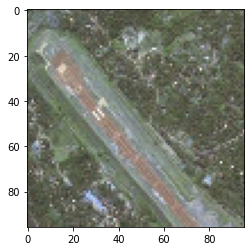

In [11]:
mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

make_example(train_loader=train_loader, classes=classes)

In [12]:
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate1 = 0.00045
MAML_learning_rate2 = 0.0001
alpha= .08
CNN_learning_rate = 0.0006
n_epochs = 80
freeze=False
First_Train = True ## note added to not load in params, always set to true in the get_model fucntion
bce_loss = nn.BCELoss()
order=True
mtype='MAML'
if First_Train: model, MAML_loss_tracker, MAML_val_topks, MAML_val_accs, epoch_tracker = train2(n_epochs=n_epochs, 
                                                                learning_rate=MAML_learning_rate1, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype)
else: 
    model = get_model(mtype)
    MAML_loss_tracker=np.load(dir+'/test/MAML_loss_tracker.npy')
    MAML_val_topks=np.load(dir+'/test/MAML_val_topks.npy')
    MAML_val_accs=np.load(dir+'/test/MAML_val_accs.npy')
    epoch_tracker=np.load(dir+'/test/'+'epoch_tracker.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 - loss: 0.068
Validation Accuracy:  15.789473533630371
Validation Top3 Accuracy:  30.921052932739258
Epoch 2 - loss: 0.065
Validation Accuracy:  14.0625
Validation Top3 Accuracy:  33.05921173095703
Epoch 3 - loss: 0.065
Validation Accuracy:  21.710525512695312
Validation Top3 Accuracy:  41.1184196472168
Epoch 4 - loss: 0.063
Validation Accuracy:  24.7532901763916
Validation Top3 Accuracy:  44.078948974609375
Epoch 5 - loss: 0.062
Validation Accuracy:  25.822368621826172
Validation Top3 Accuracy:  47.779605865478516
Epoch 6 - loss: 0.063
Validation Accuracy:  24.424341201782227
Validation Top3 Accuracy:  48.355262756347656
Epoch 7 - loss: 0.061
Validation Accuracy:  24.7532901763916
Validation Top3 Accuracy:  47.203948974609375
Epoch 8 - loss: 0.063
Validation Accuracy:  28.3717098236084
Validation Top3 Accuracy:  51.5625
Epoch 9 - loss: 0.061
Validation Accuracy:  25.822368621826172
Validation Top3 Accuracy:  49.095394134521484
Epoch 10 - loss: 0.062
Validation Accuracy:  29.85

In [13]:
make_test(model=model, testloader=test_loader)[1][1] ## just get the print statements  not the list

Test Accuracy:  60.066795349121094
Test Top3 Accuracy:  81.30963897705078


87.5

## RESISC CNN

---

## RESISC CHARTS

---

In [14]:
def getvalErr(model,val_loader):
    val_accs = []
    val_topks = []
    with torch.no_grad():
        accs, actk = [], []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        for x, y in val_loader:
            x, y = x.to(device).float(), y.to(device).long()
            yhat = model(x)
            yhat_max = torch.max(yhat, dim=1)[1]
            correct = torch.sum(yhat_max == y)
            size = x.shape[0]
            acc_topk = accuracy_topk(yhat, y)
            actk.append(acc_topk.data.item())
            valcc = 100*(correct / size).data.item()
            accs.append(valcc)
    return torch.mean(torch.FloatTensor(accs)).data.item(), 100*torch.mean(torch.FloatTensor(actk)).data.item()

## UC MERCED

---

In [15]:
UC_MAML_learning_rate = 0.0006
UC_CNN_learning_rate = 0.0006
UC_epochs = 3
UC_batch_size = 32
UC_data = np.load(dir+'data/UCMerced_images96.npy')
UC_labels = np.load(dir+'/data/UCMerced_classes.npy')
UC_classes = np.load(dir+'data/UCMerced_class_names.npy')

UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

UCtrainset = make_dataset(UC_train_data, UC_train_labels)
UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

UCtestset = make_dataset(UC_test_data, UC_test_labels)
UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)

In [16]:
def UC_train(model, trainloader, epochs=3, lr=0.0006):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    #model.load('UC')
    model.train()
    accs=0
    actk=0
    optimizer = optim.Adam(model.parameters(), lr = lr)
    for epoch in range(1, epochs+1):
        losses = 0
        for X, y in trainloader:
            y = one_hot_embedding(y.to(device), len(UC_classes)).float()
            X = X.float().to(device)
            for param in model.parameters(): param.grad = None
            yhat = model(X)
            pred_loss = bce_loss(yhat, y)
            pred_loss.backward()
            optimizer.step()
            losses += pred_loss.item()

        epoch_tracker.append(epoch)
        loss_tracker.append(losses)
        accs,actk = getvalErr(model,trainloader)
        val_accs.append(accs)
        val_topks.append(actk)
        print('Validation Accuracy: ', accs)
        print('Validation Top3 Accuracy: ', actk)

        
  
    return model, epoch_tracker, loss_tracker, val_accs, val_topks

In [17]:
mtype='MAML'
# model = get_model(mtype=mtype,firsttrain=False)

model62 = model
if freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)
/
model, epoch_tracker, MAML_loss_tracker,MAML_val_accs, MAML_val_topks = UC_train(model=model62, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation Accuracy:  71.20536041259766
Validation Top3 Accuracy:  9263.392639160156
Validation Accuracy:  88.83928680419922
Validation Top3 Accuracy:  9754.463958740234
Validation Accuracy:  94.64286041259766
Validation Top3 Accuracy:  9754.463958740234


In [18]:
make_test(model=model, testloader=UCtest_loader)[1][1]

Test Accuracy:  72.41586303710938
Test Top3 Accuracy:  91.64663696289062


96.875

## Scrap Work Area 

---

In [19]:
#GRAD DIAGNOSTICS
'''
print("PARAMS YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA == pB).all())
print("GRAD YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA.grad == pB.grad))
'''

'\nprint("PARAMS YOU ARE CHECKING")\nfor pA, pB in zip(CNN.parameters(), CNN1.parameters()):\n  print((pA == pB).all())\nprint("GRAD YOU ARE CHECKING")\nfor pA, pB in zip(CNN.parameters(), CNN1.parameters()):\n  print((pA.grad == pB.grad))\n'

In [20]:
def get_worst_task(model,val_loader):
    bytaskListACCDICT = dict.fromkeys(range(128),0)
    i=0
    for x,y in val_loader:
        actk,accs = [], []
        x = applyAugs(x.float().clone().to(device), int(i%128))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper
        y = y.float().clone().to(device)
        yhat = model(x) 
        yhat_max = torch.max(yhat, dim = 1)[1]
        correct = torch.sum(yhat_max == y)
        size = x.shape[0]
        acc_topk = accuracy_topk(yhat, y)
        actk.append(acc_topk.data.item())
        
        accs.append(100*(correct/size).data.item())
        bytaskListACCDICT[i]+=100*(correct/size).data.item()
        i+=1
    worstTASKid = min(bytaskListACCDICT, key=bytaskListACCDICT.get)
    bestTASKid = max(bytaskListACCDICT, key=bytaskListACCDICT.get)

    print(bytaskListACCDICT)
    return (bytaskListACCDICT[worstTASKid],worstTASKid), (bytaskListACCDICT[bestTASKid],bestTASKid)

worst,best = get_worst_task(get_model('MAML'),val_loader)
print(best,'= (acc percent correct,taskID) for best ')
print(worst,'= (acc percent correct,taskID) for worst ')
## plug into visulaizer and show best and worse task
## note not all entires of the dict are plugged in since the cal loader only has 1260 examples and so 19 batches
## use on a larger dataset fill in loader argument
print(val_loader.dataset.images.shape[0])

{0: 6.25, 1: 0.0, 2: 3.125, 3: 6.25, 4: 0.0, 5: 4.6875, 6: 0.0, 7: 4.6875, 8: 4.6875, 9: 4.6875, 10: 1.5625, 11: 1.5625, 12: 3.125, 13: 3.125, 14: 4.6875, 15: 1.5625, 16: 0.0, 17: 3.125, 18: 0.0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0}
(6.25, 0) = (

In [ ]:
if First_Train: model, MAML_loss_tracker, MAML_val_topks, MAML_val_accs, epoch_tracker = train2(n_epochs=n_epochs, 
                                                                learning_rate=MAML_learning_rate1, 
                                                                learning_rate1=MAML_learning_rate2, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype)
else: 
    model = get_model(mtype)
    MAML_loss_tracker=np.load(dir+'/test/MAML_loss_tracker.npy')
    MAML_val_topks=np.load(dir+'/test/MAML_val_topks.npy')
    MAML_val_accs=np.load(dir+'/test/MAML_val_accs.npy')
    epoch_tracker=np.load(dir+'/test/'+'epoch_tracker.npy')
print("don't trust this models BCE loss ")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 - loss: 0.067
Validation Accuracy:  16.776315689086914
Validation Top3 Accuracy:  34.8684196472168
Epoch 2 - loss: 0.065
Validation Accuracy:  19.736841201782227
Validation Top3 Accuracy:  37.417762756347656
Epoch 3 - loss: 0.063
Validation Accuracy:  23.519737243652344
Validation Top3 Accuracy:  45.8059196472168
Epoch 4 - loss: 0.062
Validation Accuracy:  20.394737243652344
Validation Top3 Accuracy:  40.707237243652344
Epoch 5 - loss: 0.062
Validation Accuracy:  23.273025512695312
Validation Top3 Accuracy:  45.88815689086914
Epoch 6 - loss: 0.062
Validation Accuracy:  27.05592155456543
Validation Top3 Accuracy:  48.766448974609375
Epoch 7 - loss: 0.060
Validation Accuracy:  25.904605865478516
Validation Top3 Accuracy:  48.108551025390625
Epoch 8 - loss: 0.065
Validation Accuracy:  27.302631378173828
Validation Top3 Accuracy:  48.9309196472168
Epoch 9 - loss: 0.060
Validation Accuracy:  30.098684310913086
Validation Top3 Accuracy:  55.016448974609375
Epoch 10 - loss: 0.061
Vali

In [ ]:
make_test(model=model, testloader=test_loader)


In [ ]:
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate1 = 0.0006
MAML_learning_rate2 = 0.0001
alpha= .08
CNN_learning_rate = 0.0006
n_epochs = 3
freeze=False
First_Train = True ## note added to not load in params, always set to true in the get_model fucntion
bce_loss = nn.BCELoss()
order=False
mtype='CNN'